In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import seaborn as sns
#import GMM
from statsmodels.sandbox.regression.gmm import GMM, NonlinearIVGMM, LinearIVGMM
import statsmodels.api as sm
#set seaborn graphics
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
pathdata = os.getcwd()+'/Data'
os.chdir(pathdata)
df_gdp = pd.read_pickle('ecbnew.pkl')
#df_gdp.index = df_gdp['SurveyDate']
#df_gdp = df_gdp.drop('SurveyDate', axis=1)

In [3]:
df_gdp = df_gdp.dropna()

# load shocks

In [4]:
oisfactors = pd.read_csv('dataset_con.csv')
oisfactors.index = pd.to_datetime(oisfactors['Date'])
oisfactors

,1M,3M,6M,1Y,2Y,5Y,10Y,Date,ConfFactor1,ConfFactor2,ConfFactor3
Date,,,,,,,,,,,
2002-01-03,0.0125,0.0125,0.0070,0.00500,-0.0050,-0.0105,-0.0140,2002-01-03,1.984610,-2.013147,-0.765204
2002-02-07,0.0050,0.0080,0.0050,0.01250,0.0145,0.0240,0.0210,2002-02-07,0.803178,0.588936,1.714052
2002-03-07,0.0050,0.0000,0.0020,-0.00500,-0.0050,0.0025,0.0025,2002-03-07,0.502155,-0.819328,0.754432
2002-04-04,-0.0075,-0.0125,-0.0100,-0.02250,-0.0300,-0.0240,-0.0230,2002-04-04,-0.944470,-1.100228,-1.087792
2002-05-02,0.0050,0.0200,0.0425,0.07000,0.0725,0.0615,0.0530,2002-05-02,2.389232,4.821021,1.451719
...,...,...,...,...,...,...,...,...,...,...,...
2018-03-08,-0.0018,0.0000,0.0040,-0.00175,-0.0077,-0.0258,-0.0290,2018-03-08,0.332580,-0.231835,-2.799684
2018-04-26,0.0000,0.0000,0.0000,-0.00100,-0.0030,0.0000,0.0030,2018-04-26,0.271545,-0.314816,0.421258
2018-06-14,0.0000,0.0000,0.0000,0.00000,-0.0040,-0.0080,-0.0050,2018-06-14,0.304379,-0.304242,-0.458284


In [5]:
#End of period DEFINITION - always take the last shock
mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
mpdf.index = mpdf['date']
prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
prdf.index = prdf['date']
pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
pcdf.index = pcdf['date']
pcdf = pd.concat([pcdf, oisfactors], axis = 1)
##get OLS estimate of the OIS 3Y
pcdf1 = pcdf.loc[(pcdf.index>'2001-12-01')&(pcdf.index<'2015-01-01')]
pcdf1 = pcdf1.dropna(subset=['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y', 'OIS_2Y', 'OIS_3Y'])
X = sm.add_constant(pcdf1[['OIS_1M', 'OIS_3M', 'OIS_6M', 'OIS_1Y']])
model = sm.OLS(pcdf1['OIS_3Y'], X)
results = model.fit()
#get the residuals and the fitted values
oisnew = pd.DataFrame(results.resid)
oisnew.columns = ['oisnew']
oisnew.index = pcdf1.index
oisnewfitted = pd.DataFrame(results.fittedvalues)
oisnewfitted.columns = ['oisnew_fitted']
oisnewfitted.index = pcdf1.index
pcdf = pd.concat([pcdf, oisnew], axis = 1)
pcdf = pd.concat([pcdf, oisnewfitted], axis = 1)

dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdf = mpdf.loc[(mpdf.index<date1)].tail(1)
#tale always the last announcement
for i in range(0, len(dates_list)-1):
    newdfwork = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].tail(1)
    #print(newdfwork)
    newdf = newdf.append(newdfwork)
newdf.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpr = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpr = newdfpr.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].tail(1))
newdfpr.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpc = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpc = newdfpc.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].tail(1))
newdfpc.index = dates_list

#SUM DEFINITION
#mpdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Monetary Event Window')
#mpdf.index = mpdf['date']
#prdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Release Window')
#prdf.index = prdf['date']
#pcdf = pd.read_excel('Dataset_EA-MPD.xlsx', sheet_name='Press Conference Window')
#pcdf.index = pcdf['date']
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfsum = mpdf.loc[(mpdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfworksum = mpdf.loc[(mpdf.index>dates_list[i])&(mpdf.index<dates_list[i+1])].sum()
    newdfsum = newdfsum.append(newdfwork, ignore_index = True)
newdfsum.index = dates_list
#repeat same for press conference
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfprsum = prdf.loc[(prdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfprsum = newdfprsum.append(prdf.loc[(prdf.index>dates_list[i])&(prdf.index<dates_list[i+1])].sum(), ignore_index = True)
newdfprsum.index = dates_list

#repeat same for press release
dates_list = df_gdp.index.unique()
date1=dates_list[0]
date2=dates_list[1]
newdfpcsum = pcdf.loc[(pcdf.index<date1)].tail(1)
for i in range(0, len(dates_list)-1):
    newdfpcsum = newdfpcsum.append(pcdf.loc[(pcdf.index>dates_list[i])&(pcdf.index<dates_list[i+1])].sum(),ignore_index = True)
newdfpcsum.index = dates_list

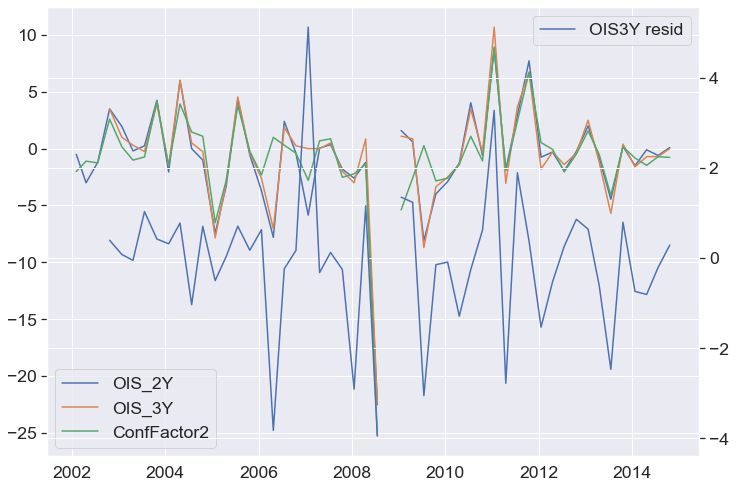

In [6]:
sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=1.6);
fig, ax1 = plt.subplots()
ax1.plot(newdfpc.loc[(newdfpc.index>'2001-12-01')&(newdfpc.index<'2015-01-01')][['OIS_2Y', 'OIS_3Y', 'ConfFactor2']])
ax1.legend(['OIS_2Y', 'OIS_3Y', 'ConfFactor2'])
ax2 = ax1.twinx()
ax2.plot(newdfpc.loc[(newdfpc.index>'2001-12-01')&(newdfpc.index<'2015-01-01')]['oisnew']);
ax2.legend(['OIS3Y resid'])

# transform data into means

In [6]:
df_gdp

,CY,1Y
Cut-off,,
2004-05-17,-0.075339,-0.065972
2004-08-20,-0.125000,-0.153333
2004-11-20,0.087196,0.129469
2005-02-18,0.183218,0.031624
2005-05-20,0.163105,-0.002108
...,...,...
2018-11-21,0.139604,0.102047
2019-02-21,0.427380,-0.104432
2019-05-22,-0.003650,-0.010347


# GMM class definition and estimation for 12 IRs

# GMM class and estimation for 8 IRs

## GMM with 2y OIS

In [41]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 8)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        #dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        #monetary policy shock
        mp = exog[:,4]
        #next year forecasts
        error1 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error2 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error3 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error4 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error5 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error6 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error7 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error8 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        #r
        #error9 = mp*(rolling1-mp*(c2))
        #error10 = mp*(rolling2-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error7, error8))
        return g

#order data
#newdfpc = newdfpc.drop(['1Y'], axis = 1)
dataols = pd.concat([df_gdp, newdfpc], axis=1)
var = 'OIS_2Y'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4, 5])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
#dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
#dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4',  var]]
#exog = dataols[[var]]
endog = dataols[['CY', '1Y']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=10,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.009233
         Iterations: 950
         Function evaluations: 1384
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 136
         Function evaluations: 242
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 131
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 516
         Function evaluations: 771
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 135
         Function evaluations: 243
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 139
         Function evaluations: 250
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 141
         Function evaluations: 247
                   

In [39]:
dataols

,CY,1Y,date,OIS_SW,OIS_1M,OIS_3M,OIS_6M,OIS_1Y,OIS_2Y,OIS_3Y,...,Date,ConfFactor1,ConfFactor2,ConfFactor3,oisnew,oisnew_fitted,D1,D2,D3,D4
Cut-off,,,,,,,,,,,,,,,,,,,,,
2004-05-17,-0.075339,-0.065972,2004-05-06,0.60,-0.45,-0.40,-0.95,0.75,1.000,1.800,...,2004-05-06,-1.151238,2.508821,-0.104021,-0.255497,2.055497,0,0,0,0
2004-11-20,0.087196,0.129469,2004-11-04,-0.50,-0.30,-0.20,-1.10,0.00,-0.250,-0.400,...,2004-11-04,-0.772616,1.131018,-1.030845,-1.268276,0.868276,0,0,0,1
2005-02-18,0.183218,0.031624,2005-02-03,-0.45,0.45,-0.85,-0.25,-0.80,-0.800,-0.100,...,2005-02-03,-0.317431,-0.131585,0.437403,0.436469,-0.536469,1,0,0,0
2005-05-20,0.163105,-0.002108,2005-05-04,-0.25,-0.10,0.00,0.25,0.70,1.500,0.650,...,2005-05-04,0.085022,1.015458,1.561257,-0.187905,0.837905,0,0,0,0
2005-11-21,-0.088793,-0.168966,2005-11-03,0.00,-0.50,-0.50,-0.50,-0.05,0.100,0.150,...,2005-11-03,-0.755882,1.248683,-0.410076,-0.126124,0.276124,0,0,0,1
2006-02-17,-0.140229,-0.092885,2006-02-02,0.00,0.00,0.25,0.25,0.40,0.650,0.500,...,2006-02-02,0.221155,0.586625,0.532073,0.261925,0.238075,1,0,0,0
2006-05-19,-0.017438,0.112745,2006-05-04,0.00,0.40,1.00,0.60,1.10,0.950,0.850,...,2006-05-04,0.985713,0.235572,0.272292,-0.098305,0.948305,0,0,0,0
2006-08-18,-0.346138,-0.253789,2006-08-03,-0.80,-1.20,1.10,1.40,2.50,3.050,3.200,...,2006-08-03,0.260588,3.106628,0.264943,1.511475,1.688525,0,0,1,0
2006-11-24,-0.132691,-0.167597,2006-11-02,-1.55,-0.30,-0.20,0.30,0.60,0.600,0.550,...,2006-11-02,-0.023585,0.908735,-0.168201,-0.064043,0.614043,0,0,0,1


## OIS residuals from regression

In [42]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        twoY = endog[:,2]
        rolling1 = endog[:,3]
        rolling2 = endog[:,4]
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts
        error11 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error1 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error2 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error3 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error12 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error4 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error5 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error6 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        #r
        error13 = mp*(rolling1-mp*(c2))
        error14 = mp*(rolling2-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error11, error12, error13, error14))
        return g

#order data
dataols = pd.concat([df1gdpmeans, newdfpc], axis=1)
var = 'oisnew'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2001-12-01')&(dataols.index<'2015-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'TwoYearDiff', 'R1', 'R2']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=20,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.085147
         Iterations: 1011
         Function evaluations: 1486
Optimization terminated successfully.
         Current function value: 0.081758
         Iterations: 1006
         Function evaluations: 1472
Optimization terminated successfully.
         Current function value: 0.081647
         Iterations: 705
         Function evaluations: 1064
Optimization terminated successfully.
         Current function value: 0.081450
         Iterations: 767
         Function evaluations: 1125
Optimization terminated successfully.
         Current function value: 0.081333
         Iterations: 711
         Function evaluations: 1058
Optimization terminated successfully.
         Current function value: 0.081277
         Iterations: 127
         Function evaluations: 223
Optimization terminated successfully.
         Current function value: 0.081292
         Iterations: 124
         Function evaluations: 225
Optimization 

In [44]:
cumsumCI = np.zeros((8, 3))
#first estimate c0
samplesize = 72
mean = res.params[0] 
cov = res.cov_params()[0,0]*samplesize
upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
cumsumCI[0, 0] = lowB
cumsumCI[0, 1] = mean
cumsumCI[0, 2] = upB
#we continue for the other coefficients
for i in range(1, 8):
    #get the new mean
    mean = mean + res.params[i]
    #add the variance
    cov = cov + res.cov_params()[i,i]*samplesize
    #add the covariances
    for j in range(0, i):
        cov = cov + 2*res.cov_params()[j,i]*samplesize
    upB = mean + 1.96*np.sqrt(cov)/np.sqrt(72)
    lowB = mean - 1.96*np.sqrt(cov)/np.sqrt(72)
    cumsumCI[i, 0] = lowB
    cumsumCI[i, 1] = mean
    cumsumCI[i, 2] = upB

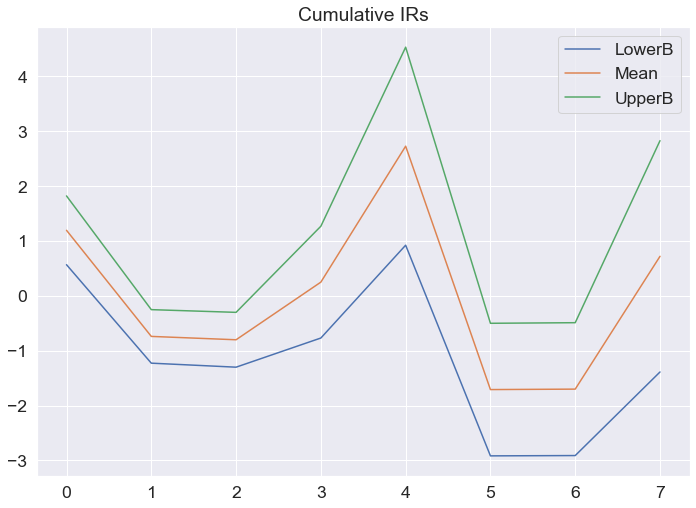

In [46]:
pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB'])
plt.plot(pd.DataFrame(cumsumCI, columns=['LowerB', 'Mean', 'UpperB']));
plt.legend(['LowerB', 'Mean', 'UpperB']);
plt.title('Cumulative IRs');

In [45]:
dataols.to_csv('gdpdata.csv')

## GMM with FG factor

In [12]:
'''
'''
class mpGMM(GMM):
    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 10)
        kwds.setdefault('k_params', 8)
        super(mpGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        c0, c1, c2, c3, c4, c5, c6, c7 = params
        endog = self.endog
        exog = self.exog
        #defining variables
        #interaction dummies
        dQ1 = exog[:,0]
        dQ2 = exog[:,1]
        dQ3 = exog[:,2]
        dQ4 = exog[:,3]
        dTY = exog[:,4]
        #endogenous variables
        currentY = endog[:,0]
        nextY = endog[:,1]
        twoY = endog[:,2]
        rolling1 = endog[:,3]
        rolling2 = endog[:,4]
        #monetary policy shock
        mp = exog[:,5]
        #next year forecasts
        error11 = dQ1*mp*(nextY-mp*(1/4*c1+1/2*c2+3/4*c3+1*c4+3/4*c5+1/2*c6+1/4*c7)*dQ1)
        error1 = dQ2*mp*(nextY-mp*(1/4*c0+1/2*c1+3/4*c2+1*c3+3/4*c4+1/2*c5+1/4*c6)*dQ2)
        error2 = dQ3*mp*(nextY-mp*(1/2*c0+3/4*c1+1*c2+3/4*c3+1/2*c4+1/4*c5)*dQ3)
        error3 = dQ4*mp*(nextY-mp*(3/4*c0+1*c1+3/4*c2+1/2*c3+1/4*c4)*dQ4)
        #current year forecasts
        error12 = dQ1*mp*(currentY-mp*(c0+3/4*c1+1/2*c2+1/4*c3)*dQ1)
        error4 = dQ2*mp*(currentY-mp*(3/4*c0+1/2*c1+1/4*c2)*dQ2)
        error5 = dQ3*mp*(currentY-mp*(1/2*c0+1/4*c1)*dQ3)
        error6 = dQ4*mp*(currentY-mp*(1/4*c0)*dQ4)
        #rolling forecasts
        #r
        error13 = mp*(rolling1-mp*(c2))
        error14 = mp*(rolling2-mp*(c6))
        g = np.column_stack((error1, error2, error3, error4, error5, error6, 
                            error11, error12, error13, error14))
        return g

#order data
dataols = pd.concat([df1gdpmeans, newdfpc], axis=1)
var = 'ConfFactor2'
dataols = dataols.dropna(subset = [var]).iloc[:-1,:]
#time periods
dataols = dataols.loc[(dataols.index>'2002-12-01')&(dataols.index<'2014-01-01')]
#dataols = dataols.loc[dataols.index>'2002-01-01']
#create dummies
dataols['D1'] = (dataols.index.month.isin([1,2])==True)*1
dataols['D2'] = (dataols.index.month.isin([3,4])==True)*1
dataols['D3'] = (dataols.index.month.isin([7,8])==True)*1
dataols['D4'] = (dataols.index.month.isin([10,11])==True)*1
dataols['DTY'] = (dataols['TwoYearDiff'].isnull()==False)*1
dataols['TwoYearDiff'] = dataols['TwoYearDiff'].fillna(value=0)
exog = dataols[['D1', 'D2', 'D3', 'D4', 'DTY', var]]
#exog = dataols[[var]]
endog = dataols[['CurrentYearDiff', 'OneYearDiff', 'TwoYearDiff', 'R1', 'R2']].copy()
#instr = np.asarray(exogt.iloc[:, 4:])
model = mpGMM(endog, exog,  None)
beta0 = np.zeros((1, 8))
res = model.fititer(beta0, maxiter=100, optim_method='nm',   weights_method='cov',
                  wargs={'centered':False})
#,  weights_method='cov',
#                    wargs={'centered':False}
w0 = res[1]
inv_weights = np.linalg.inv(w0)
#inv_weights =inv_weights,
res = model.fit(beta0, maxiter=30,   inv_weights =inv_weights, optim_method='nm',   weights_method='cov',
                   wargs={'centered':False})
print(res.summary(yname='GDP forecast diff', xname=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']))

Optimization terminated successfully.
         Current function value: 0.063565
         Iterations: 214
         Function evaluations: 317
Optimization terminated successfully.
         Current function value: 0.046317
         Iterations: 739
         Function evaluations: 1091
Optimization terminated successfully.
         Current function value: 0.044904
         Iterations: 531
         Function evaluations: 797
Optimization terminated successfully.
         Current function value: 0.043030
         Iterations: 929
         Function evaluations: 1357
Optimization terminated successfully.
         Current function value: 0.041435
         Iterations: 563
         Function evaluations: 847
Optimization terminated successfully.
         Current function value: 0.040427
         Iterations: 468
         Function evaluations: 712
Optimization terminated successfully.
         Current function value: 0.039795
         Iterations: 378
         Function evaluations: 585
Optimization termi